## Clustering de series temporales

`tslearn` es una librería de Machine Learning de Python para series temporales que ofrece herramientas para el preprocesamiento y la extracción de características, así como modelos dedicados para clustering, clasificación y regresión. En esta rápida prueba de concepto, vamos a realizar una tarea de clustering de un dataset de una sola variable bien conocido.

In [1]:
#!pip install tslearn

En el siguiente [enlace](www.timeseriesclassification.com/dataset.php) se puede consultar la extensa lista de datasets de series temporales a la que podemos acceder. En este artículo vamos a trabajar con el dataset **ECG5000**. Este dataset contiene 20 horas de registros de electrocardiogramas (ECGs).

In [2]:
import tslearn
import numpy as np
import time
import matplotlib.pyplot as plt

# media nula y una desviación típica 1
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.datasets import UCR_UEA_datasets

X_test, y_test, X_train, y_train = UCR_UEA_datasets().load_dataset("ECG5000")

Las etiquetas del dataset tienen el siguiente significado:

1. N – Normal
2. SVEB – Supraventricular ectopic beats
3. VEB – Ventricular ectopic beats
4. Fusion beat
5. Unknown beat

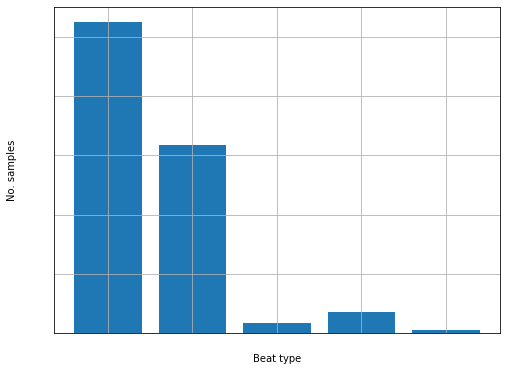

In [3]:
labels, counts = np.unique(y_train, return_counts=True)
_labels = ["Normal", "SVEB", "VEB", "Fusion", "Unknown"]
plt.figure(figsize=(8, 6))
plt.bar(_labels, counts, align="center")
plt.gca().set_xticks(_labels)
plt.grid()
plt.ylabel("No. samples")
plt.xlabel("Beat type")
plt.tick_params(axis="x", colors="white")
plt.tick_params(axis="y", colors="white")
plt.show()

Como se puede observar, el dataset está muy desbalanceado. Hay muy pocas muestras de las clases y_train > 2 en comparación con los latidos normales o SVEB. Por ello, para simplificar el análisis, vamos a partir el dataset en latidos normales y latidos anómalos.

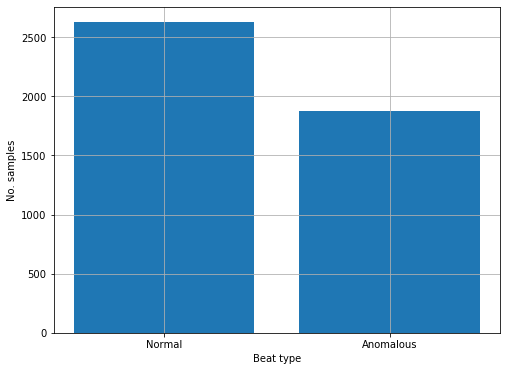

In [4]:
y_test[y_test == 1] = 0
y_test[y_test > 1] = 1

y_train[y_train == 1] = 0
y_train[y_train > 1] = 1

labels, counts = np.unique(y_train, return_counts=True)
_labels = ["Normal", "Anomalous"]
plt.figure(figsize=(8, 6))
plt.bar(_labels, counts, align="center")
plt.gca().set_xticks(_labels)
plt.grid()
plt.ylabel("No. samples")
plt.xlabel("Beat type")
plt.show()

Debemos escalar nuestras series temporales para poder obtener buenos resultados de clustering.

Shape x_train (4500, 140, 1)
Shape x_test (500, 140, 1)


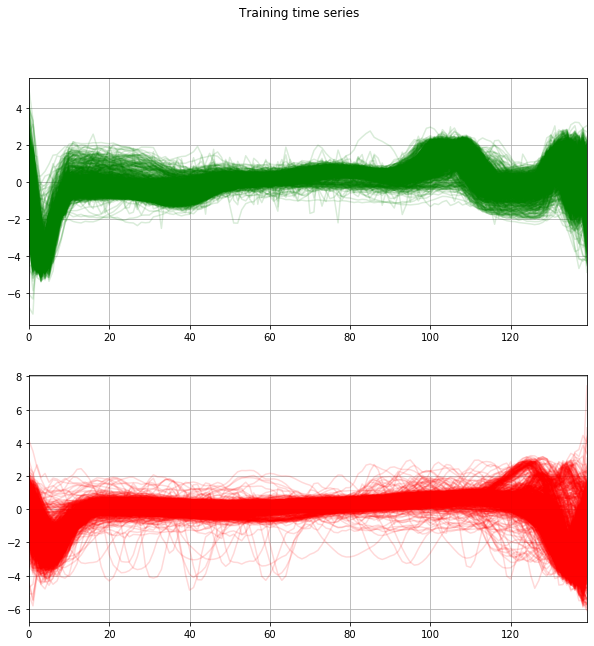

In [5]:
X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train)
X_test = TimeSeriesScalerMeanVariance().fit_transform(X_test)

print("Shape x_train", X_train.shape)
print("Shape x_test", X_test.shape)

size = X_train.shape[1]
n_classes = len(set(y_train))

plt.figure(figsize=(10, 10))
for i, cl in enumerate(set(y_train)):
    plt.subplot(n_classes, 1, i + 1)
    for ts in X_train[y_train == cl]:
        if cl == 0:
            plt.plot(ts.ravel(), color="green", alpha=.15)
        else:
            plt.plot(ts.ravel(), color="red", alpha=.15)
    plt.xlim(0, size - 1)
    plt.grid()
plt.suptitle("Training time series")
plt.show()

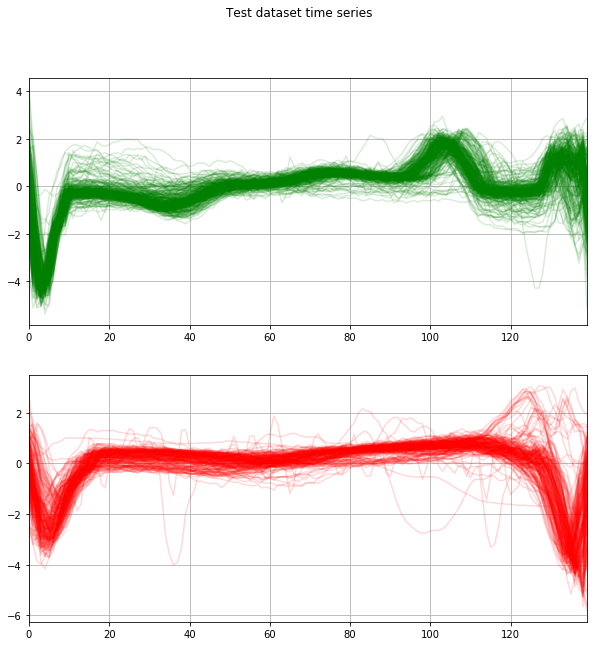

In [6]:
plt.figure(figsize=(10, 10))
for i, cl in enumerate(set(y_train)):
    plt.subplot(n_classes, 1, i + 1)
    for ts in X_test[y_test == cl]:
        if cl == 0:
            plt.plot(ts.ravel(), color="green", alpha=.15)
        else:
            plt.plot(ts.ravel(), color="red", alpha=.15)
    plt.xlim(0, size - 1)
    plt.grid()
plt.suptitle("Test dataset time series")
plt.show()

A simple vista, únicamente en base a la forma, es sencillo distinguir entre los latidos de un individuo sano y los de un paciente con una patología (sin especificar).

### Clustering de secuencias

Vamos a probar dos algoritmos de clustering: K-Means y K-Shape. Para el caso de K-Means, vamos a centrarnos únicamente en la métrica “euclidean”. Hay otras dos alternativas para este hiperparámetro: “dtw” y “softdtw”.

In [7]:
from tslearn.clustering import TimeSeriesKMeans, KShape, silhouette_score

/opt/conda/lib/python3.7/site-packages/tslearn/clustering/kmeans.py:17: UserWarning: Scikit-learn <0.24 will be deprecated in a future release of tslearn
  "Scikit-learn <0.24 will be deprecated in a "


##### Time Series K-Means para dos clusters

In [8]:
start_time = time.time()

km_euc = TimeSeriesKMeans(n_clusters=2,
                          verbose=2,
                          n_init=10,
                          metric="euclidean").fit(X_train)
labels_euc = km_euc.labels_

print("--- %s seconds ---" % (time.time() - start_time))

Init 1
52.363 --> 33.808 --> 33.717 --> 33.716 --> 33.716 --> 33.716 --> 33.716 --> 
Init 2
61.918 --> 33.751 --> 33.716 --> 33.716 --> 33.716 --> 33.716 --> 
Init 3
47.064 --> 33.745 --> 33.716 --> 33.716 --> 33.716 --> 
Init 4
67.371 --> 33.781 --> 33.717 --> 33.716 --> 33.716 --> 33.716 --> 
Init 5
47.811 --> 33.758 --> 33.716 --> 33.716 --> 33.716 --> 33.716 --> 
Init 6
47.645 --> 33.918 --> 33.721 --> 33.716 --> 33.716 --> 33.716 --> 
Init 7
44.564 --> 33.754 --> 33.716 --> 33.716 --> 33.716 --> 
Init 8
42.830 --> 33.761 --> 33.717 --> 33.716 --> 33.716 --> 33.716 --> 
Init 9
70.501 --> 34.962 --> 33.784 --> 33.719 --> 33.716 --> 33.716 --> 33.716 --> 
Init 10
64.701 --> 35.107 --> 33.807 --> 33.720 --> 33.716 --> 33.716 --> 33.716 --> 
--- 18.936834573745728 seconds ---


##### Time Series K-Shape para dos clusters

In [9]:
start_time = time.time()

ks = KShape(n_clusters=2, verbose=True, n_init=10).fit(X_train)
labels_kshape = ks.labels_

print("--- %s seconds ---" % (time.time() - start_time))

Init 1
0.081 --> 0.073 --> 0.053 --> 0.033 --> 0.029 --> 0.029 --> 
Init 2
0.023 --> 0.024 --> 
Init 3
0.025 --> 0.024 --> 0.026 --> 
Init 4
0.022 --> 0.022 --> 0.024 --> 
Init 5
0.023 --> 0.025 --> 
Init 6
0.067 --> 0.070 --> 
Init 7
0.071 --> 0.069 --> 0.069 --> 
Init 8
0.098 --> 0.045 --> 0.029 --> 0.031 --> 
Init 9
0.054 --> 0.042 --> 0.031 --> 0.028 --> 0.028 --> 
Init 10
0.066 --> 0.056 --> 0.030 --> 0.027 --> 0.028 --> 
--- 113.56736946105957 seconds ---


Las silhouette scores de ambas soluciones son muy similares:

In [10]:
print("Silhouwttw Score")
print("X_train: ", silhouette_score(X_train, labels_euc, metric="euclidean"))
print("X_test: ", silhouette_score(X_train, labels_kshape, metric="euclidean"))

Silhouwttw Score
X_train:  0.45911902366303975
X_test:  0.45526176815396047


#### Resultados de los agrupamientos

Dado que contamos con las etiquetas del dataset, podemos comprobar cómo de bien hemos agrupado los electrocardiogramas entre pacientes sanos o con patologías.

In [11]:
from sklearn.metrics import accuracy_score

In [12]:
print("Training dataset accuracy for TimeSeriesKMeans clustering with euclidean metric: ",
      accuracy_score(y_train, labels_euc))
print("Training dataset accuracy for KShape clustering: ",
      accuracy_score(y_train, labels_kshape))
print("Test dataset accuracy for TimeSeriesKMeans clustering with euclidean metric: ",
      accuracy_score(y_test, km_euc.predict(X_test)))
print("Test dataset accuracy for KShape clustering: ",
      accuracy_score(y_test, ks.predict(X_test)))

Training dataset accuracy for TimeSeriesKMeans clustering with euclidean metric:  0.9411111111111111
Training dataset accuracy for KShape clustering:  0.06133333333333333
Test dataset accuracy for TimeSeriesKMeans clustering with euclidean metric:  0.958
Test dataset accuracy for KShape clustering:  0.044


Vamos a analizar, con matrices de confusión, los errores de [Tipo I y Tipo II](https://es.wikipedia.org/wiki/Errores_de_tipo_I_y_de_tipo_II) en los que nuestros modelos de clustering está incurriendo.

In [13]:
from sklearn.metrics import confusion_matrix

print("Training dataset TimeSeriesKMeans confusion matrix\n",
      confusion_matrix(y_train, labels_euc), "\n")
print("Training dataset KShape confusion matrix\n",
      confusion_matrix(y_train, labels_kshape), "\n")
print("Test dataset TimeSeriesKMeans confusion matrix\n",
      confusion_matrix(y_test, km_euc.predict(X_test)), "\n")
print("Test dataset KShape confusion matrix\n",
      confusion_matrix(y_test, ks.predict(X_test)), "\n")

Training dataset TimeSeriesKMeans confusion matrix
 [[2563   64]
 [ 201 1672]] 

Training dataset KShape confusion matrix
 [[  85 2542]
 [1682  191]] 

Test dataset TimeSeriesKMeans confusion matrix
 [[283   9]
 [ 12 196]] 

Test dataset KShape confusion matrix
 [[ 10 282]
 [196  12]] 



#### Representando los clusters y sus centroides

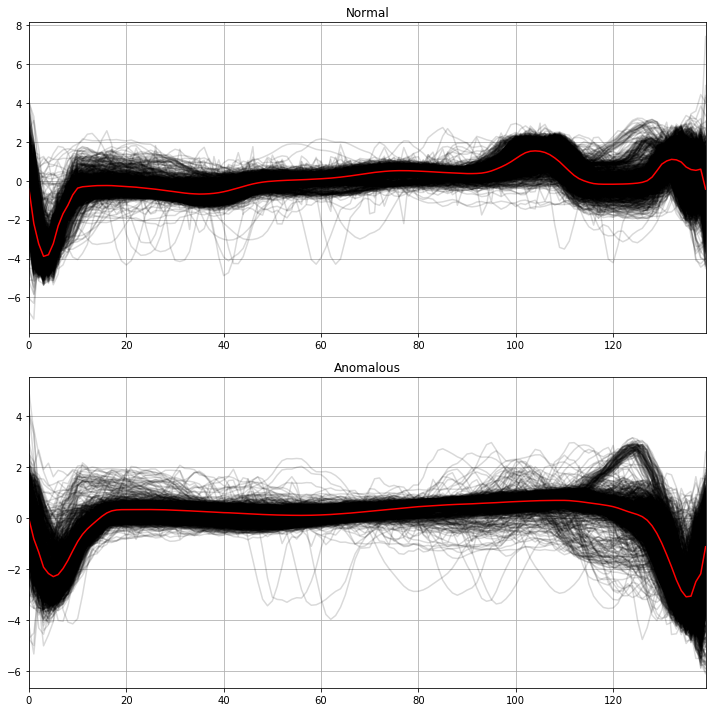

In [14]:
def plot_groups(model):
    if model == "kmeans-euclidean":
        model = km_euc
    elif model == "kshape":
        model = ks
    else:
        sys.exit("Please, provide a valid model string.")

    labels = model.labels_
    plt.figure(figsize=(10, 10))

    for yi in range(2):
        plt.subplot(2, 1, 1 + yi)
        for xx in X_train[labels == yi]:
            plt.plot(xx.ravel(), "k-", alpha=.15)
        plt.plot(model.cluster_centers_[yi].ravel(), "r-")
        plt.xlim(0, size - 1)
        if yi == 0:
            plt.title("Normal")
        else:
            plt.title("Anomalous")
        plt.grid()

    plt.tight_layout()
    plt.show()


plot_groups(model="kmeans-euclidean")

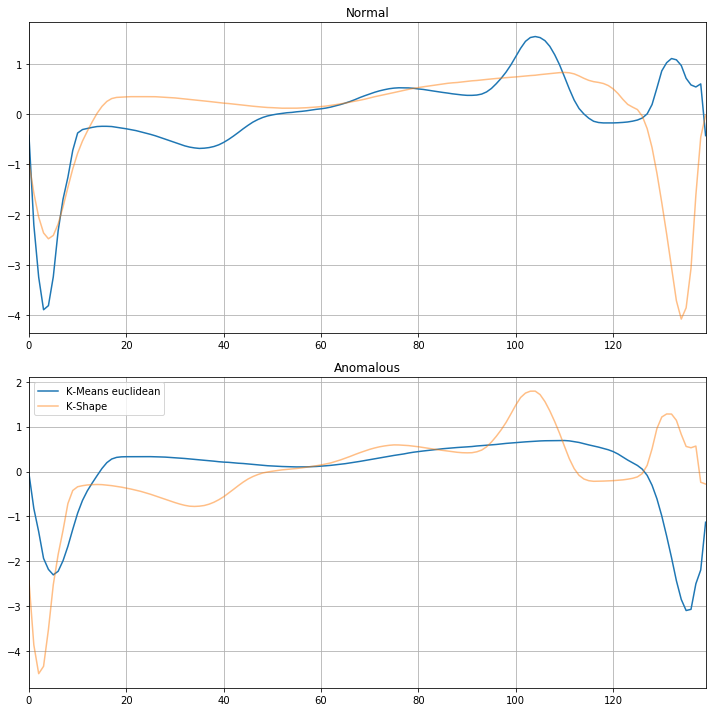

In [15]:
def compare_cluster_centers():
    plt.figure(figsize=(10, 10))
    for yi in range(2):
        plt.subplot(2, 1, 1 + yi)
        plt.plot(km_euc.cluster_centers_[yi].ravel(),
                 "-",
                 alpha=1.,
                 label="K-Means euclidean")
        #plt.plot(km_softdtw.cluster_centers_[yi].ravel(), "-", alpha=0.5, label="K-Means softdtw")
        plt.plot(ks.cluster_centers_[yi].ravel(),
                 "-",
                 alpha=.5,
                 label="K-Shape")
        if yi == 0:
            plt.title("Normal")
        else:
            plt.title("Anomalous")

        plt.xlim(0, size - 1)
        plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.show()


compare_cluster_centers()

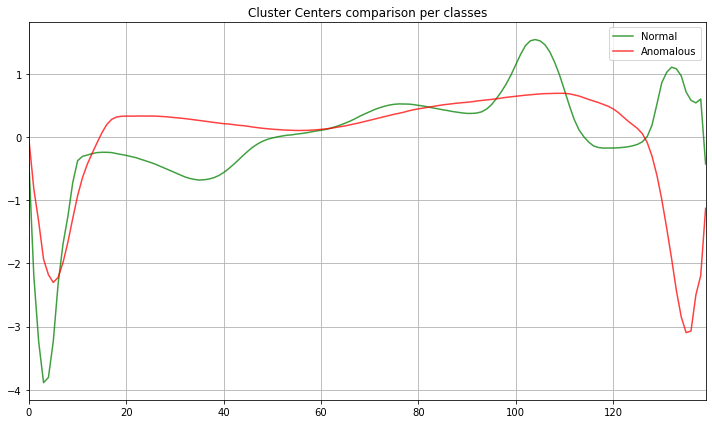

In [16]:
def compare_cluster_centers_classes():
    plt.figure(figsize=(10, 6))
    plt.plot(km_euc.cluster_centers_[0].ravel(),
             "-",
             c="green",
             alpha=.75,
             label="Normal")
    plt.plot(km_euc.cluster_centers_[1].ravel(),
             "-",
             c="red",
             alpha=.75,
             label="Anomalous")
    plt.xlim(0, size - 1)
    plt.title("Cluster Centers comparison per classes")
    plt.tight_layout()
    plt.legend()
    plt.grid()
    plt.show()


compare_cluster_centers_classes()